In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from tensorflow.keras.datasets import mnist

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

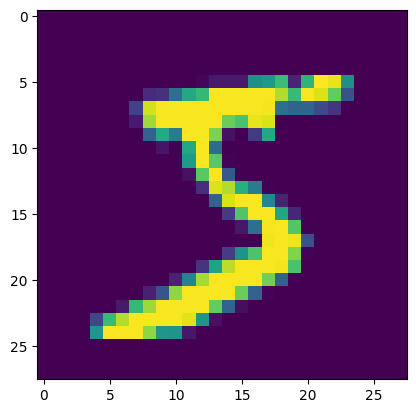

In [5]:
plt.imshow(X_train[0])

## Filtrer les données pour un entraînement plus rapide sur un plus petit ensemble de données

(5923, 28, 28)


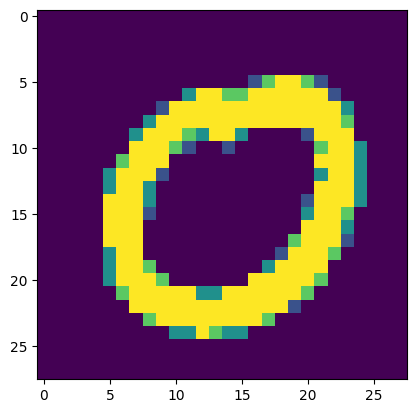

In [7]:
only_zeros = X_train[y_train==0]
print(only_zeros.shape)
plt.imshow(only_zeros[950]);

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Flatten
from tensorflow.keras.models import Sequential

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [10]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150,activation='relu'))
discriminator.add(Dense(100,activation='relu'))
discriminator.add(Dense(1,activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy", optimizer="adam")

In [11]:
generator = Sequential()
generator.add(Dense(100, activation="relu", input_shape=[codings_size]))
generator.add(Dense(150,activation='relu'))
generator.add(Dense(784, activation="sigmoid")) # 28*28 = 784
generator.add(Reshape([28,28]))

In [12]:
GAN = Sequential([generator, discriminator])

In [13]:
discriminator.trainable = False

In [14]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [15]:
GAN.layers

In [16]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28)            143634    
                                                                 
 sequential (Sequential)     (None, 1)                 132951    
                                                                 
Total params: 276585 (1.06 MB)
Trainable params: 143634 (561.07 KB)
Non-trainable params: 132951 (519.34 KB)
_________________________________________________________________


In [17]:
GAN.layers[0].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 150)               15150     
                                                                 
 dense_5 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 143634 (561.07 KB)
Trainable params: 143634 (561.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
GAN.layers[1].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 150)               117750    
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 132951 (519.34 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 132951 (519.34 KB)
_________________________________________________________________


### Mise en place des batches d'entraînement

In [20]:
import tensorflow as tf

In [21]:
batch_size = 32

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

Le paramètre buffer_size dans Dataset.shuffle() peut affecter le caractère aléatoire de votre ensemble de données, et donc l'ordre dans lequel les éléments sont produits.

In [22]:
# my_data = X_train
my_data = only_zeros

In [23]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [24]:
type(dataset)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [25]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [26]:
epochs = 1

**NOTE : Le générateur ne voit jamais d'images réelles. Il apprend en regardant les gradients qui remontent à travers le discriminateur. Plus le discriminateur s'améliore au cours de l'entraînement, plus il contient d'informations dans ses gradients, ce qui signifie que le générateur peut être amené à progresser dans l'apprentissage de la génération de fausses images, dans notre cas, de faux zéros.**

## Boucle d'Entraînement

In [27]:
# Saisir les composants séparés
generator, discriminator = GAN.layers

# Pour chaque epoch
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # Pour chaque batch dans le dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")

        #########################################
        ## ENTRAINEMENT DU DISCRIMINATEUR ######
        #######################################

        # Créer du bruit
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Générer des nombres basés uniquement sur ce bruit d'entrée
        gen_images = generator(noise)

        # Concaténer les images générées avec les images réelles
        # POUR utiliser tf.concat, les types de données doivent correspondre !
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)

        # Cibles fixées à zéro pour les fausses images et à 1 pour les images réelles
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

        # Cela permet de se débarrasser d'un avertissement Keras
        discriminator.trainable = True

        # Entraîner le discriminateur sur ce batch
        discriminator.train_on_batch(X_fake_vs_real, y1)


        #####################################
        ## ENTRAINEMENT DU GÉNÉRATEUR ######
        ###################################

        # Créer un peu de bruit
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Nous voulons que les discriminateurs croient que les fausses images sont réelles
        y2 = tf.constant([[1.]] * batch_size)

        # Éviter un avertissement
        discriminator.trainable = False

        GAN.train_on_batch(noise, y2)

print("TRAINING COMPLETE")

Currently on Epoch 1



	Currently on batch number 100 of 185
TRAINING COMPLETE


In [28]:
# Il est fort probable que votre générateur n'apprenne à créer qu'un seul type de bruit zéro
# Quel que soit le bruit qui y passe.

https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same

In [29]:
noise = tf.random.normal(shape=[10, codings_size])

In [30]:
noise.shape

TensorShape([10, 100])

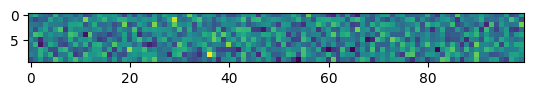

In [31]:
plt.imshow(noise)

In [32]:
image = generator(noise)

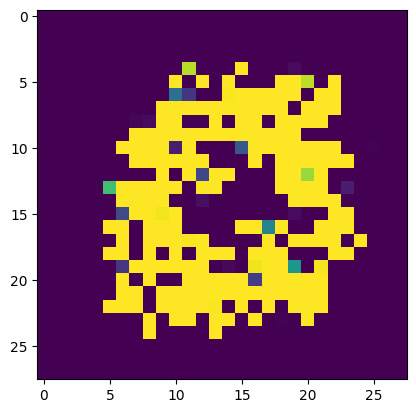

In [33]:
plt.imshow(image[5])

**Visionnez notre vidéo de conclusion pour connaître les meilleures pratiques dans ce domaine ! Nous avons besoin de GPUs très puissants pour obtenir des résultats réalistes !**